In [19]:
!pip uninstall -y tensorflow tensorflow_hub
!pip install tensorflow==2.12 tensorflow_hub==0.13.0


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub


In [2]:
df = pd.read_csv("wine-reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
df=df.dropna(subset=['description', 'points'])

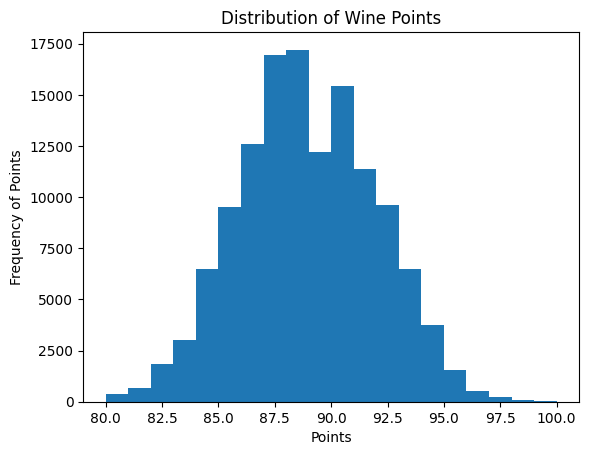

In [4]:
plt.hist(df.points, bins=20)
plt.title("Distribution of Wine Points")
plt.xlabel("Points")
plt.ylabel("Frequency of Points")
plt.show()

In [5]:
df["label"]= (df.points >= 90).astype(int)
df=df[['description', 'label']]

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [8]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [9]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"This is the last Wild Sky to be crafted by now-departed winemaker Gordy Hill. It's a full-on Bordeaux blend, 88% Cabernet Sauvignon, with the other four grapes filling in the rest. Substantial and mouth-filling, it displays a mix of black fruits, black olive, and Italian herbs. The mouthfeel is satisfying and the finish edged with dark chocolate.",
        b'This wine is an unusual blend of Barbera (40%), Malbec (25%), Sangiovese (21%) and Cabernet Franc. It works, with aromas of sweet baking spices, vanilla, cherry and herb that are followed by generous, velvety cherry flavors. The oak is very primary but it still brings appeal.',
        b"This has subtle flavors of strawberries, limes, dough and vanilla smoke. It's a little rough in the mouth, with a scoury texture, but it's a good buy at this price.",
        ...,
        b"Briary berry and cedar flavors are marred by less ripe notes of green herbs. It's dry, tannic and spi

In [10]:
#embedding text
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [11]:
#transformed text (reviews) into vectors
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.40077826, -0.26980445,  0.02519822, ...,  0.15033264,
        -0.03938355, -0.15809697],
       [ 0.00170376,  0.00791128,  0.01286772, ..., -0.34281322,
        -0.08888466,  0.18024781],
       [ 0.17892347, -0.13066472, -0.04190937, ...,  0.04312802,
        -0.27281198,  0.0162894 ],
       ...,
       [ 0.14914425, -0.47110453, -0.11642956, ..., -0.03165505,
        -0.19018097, -0.00794437],
       [ 0.45512605, -0.00448721, -0.20221186, ..., -0.00496146,
         0.0152952 ,  0.0593897 ],
       [ 0.84444076, -0.491186  , -0.05990171, ...,  0.09725188,
        -0.13861324,  0.18995814]], dtype=float32)>

In [18]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [20]:
model.evaluate(train_data)


102/102 [==============================] - 19s 179ms/step - loss: 0.6725 - accuracy: 0.6246


[0.6725375056266785, 0.6246153116226196]

In [21]:
model.evaluate(valid_data)

13/13 [==============================] - 2s 168ms/step - loss: 0.6729 - accuracy: 0.6240


[0.672903835773468, 0.6239901781082153]

In [22]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 132s 1s/step - loss: 0.5395 - accuracy: 0.7239 - val_loss: 0.4021 - val_accuracy: 0.8225
Epoch 2/5
102/102 [==============================] - 146s 1s/step - loss: 0.3905 - accuracy: 0.8371 - val_loss: 0.3802 - val_accuracy: 0.8271
Epoch 3/5
102/102 [==============================] - 134s 1s/step - loss: 0.3517 - accuracy: 0.8579 - val_loss: 0.3838 - val_accuracy: 0.8269
Epoch 4/5
102/102 [==============================] - 135s 1s/step - loss: 0.3324 - accuracy: 0.8672 - val_loss: 0.3891 - val_accuracy: 0.8263
Epoch 5/5
102/102 [==============================] - 134s 1s/step - loss: 0.3166 - accuracy: 0.8743 - val_loss: 0.3892 - val_accuracy: 0.8264


In [23]:
model.evaluate(test_data)

13/13 [==============================] - 3s 176ms/step - loss: 0.3849 - accuracy: 0.8297


[0.3849286735057831, 0.8297430276870728]

In [24]:
#LSTM

encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [25]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [28]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 182ms/step - loss: 0.6931 - accuracy: 0.5063


[0.693149745464325, 0.506270706653595]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 59s 509ms/step - loss: 0.5465 - accuracy: 0.7100 - val_loss: 0.3800 - val_accuracy: 0.8277
Epoch 2/5
102/102 [==============================] - 52s 488ms/step - loss: 0.3666 - accuracy: 0.8362 - val_loss: 0.3551 - val_accuracy: 0.8390
Epoch 3/5
102/102 [==============================] - 49s 476ms/step - loss: 0.3496 - accuracy: 0.8446 - val_loss: 0.3520 - val_accuracy: 0.8409
Epoch 4/5
102/102 [==============================] - 52s 505ms/step - loss: 0.3409 - accuracy: 0.8484 - val_loss: 0.3500 - val_accuracy: 0.8432
Epoch 5/5
 18/102 [====>.........................] - ETA: 42s - loss: 0.3324 - accuracy: 0.8548

In [30]:
model.evaluate(test_data)

13/13 [==============================] - 2s 164ms/step - loss: 0.3584 - accuracy: 0.8412


[0.3583644926548004, 0.8412063121795654]